In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

DATA_PATH = "../data/"

gen1 = pd.read_csv(DATA_PATH + "Plant_1_Generation_Data.csv")
gen2 = pd.read_csv(DATA_PATH + "Plant_2_Generation_Data.csv")
weather1 = pd.read_csv(DATA_PATH + "Plant_1_Weather_Sensor_Data.csv")
weather2 = pd.read_csv(DATA_PATH + "Plant_2_Weather_Sensor_Data.csv")

print("Plant 1 Generation:", gen1.shape)
print("Plant 2 Generation:", gen2.shape)
print("Plant 1 Weather:", weather1.shape)
print("Plant 2 Weather:", weather2.shape)

Plant 1 Generation: (68778, 7)
Plant 2 Generation: (67698, 7)
Plant 1 Weather: (3182, 6)
Plant 2 Weather: (3259, 6)


In [2]:
gen1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [3]:
weather1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [4]:
# Parse dates and combine datasets
gen1['DATE_TIME'] = pd.to_datetime(gen1['DATE_TIME'], format='%d-%m-%Y %H:%M')
gen2['DATE_TIME'] = pd.to_datetime(gen2['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
weather1['DATE_TIME'] = pd.to_datetime(weather1['DATE_TIME'])
weather2['DATE_TIME'] = pd.to_datetime(weather2['DATE_TIME'])

gen = pd.concat([gen1, gen2], ignore_index=True)
weather = pd.concat([weather1, weather2], ignore_index=True)

# Merge on datetime and plant
df = gen.merge(weather[['DATE_TIME', 'PLANT_ID', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']], 
               on=['DATE_TIME', 'PLANT_ID'], how='inner')

print("Merged shape:", df.shape)
df.head()

Merged shape: (136472, 10)


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0


In [5]:
# Check missing values and basic stats
print(df.isnull().sum())
print("\n", df.describe())

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

                            DATE_TIME      PLANT_ID       DC_POWER  \
count                         136472  1.364720e+05  136472.000000   
mean   2020-06-01 09:22:57.605662464  4.135497e+06    1708.373962   
min              2020-05-15 00:00:00  4.135001e+06       0.000000   
25%              2020-05-23 23:00:00  4.135001e+06       0.000000   
50%              2020-06-01 18:45:00  4.135001e+06       5.993333   
75%              2020-06-09 21:45:00  4.136001e+06    1155.595000   
max              2020-06-17 23:45:00  4.136001e+06   14471.125000   
std                              NaN  4.999863e+02    3222.079306   

            AC_POWER    DAILY_YIELD   TOTAL_YIELD  AMBIENT_TEMPERATURE  \
count  136472.000000  136472.000000  1.

In [6]:
# Filter to daylight hours only (when irradiation > 0) - nighttime data is not useful
df_day = df[df['IRRADIATION'] > 0].copy()
print("Daytime records:", df_day.shape[0])

# Feature engineering
df_day['HOUR'] = df_day['DATE_TIME'].dt.hour
df_day['TEMP_DIFF'] = df_day['MODULE_TEMPERATURE'] - df_day['AMBIENT_TEMPERATURE']

# Efficiency: AC_POWER per unit irradiation (avoid div by 0)
df_day['EFFICIENCY'] = df_day['AC_POWER'] / df_day['IRRADIATION']

# DC to AC conversion efficiency
df_day['DC_AC_RATIO'] = np.where(df_day['DC_POWER'] > 0, df_day['AC_POWER'] / df_day['DC_POWER'], 0)

df_day.head()

Daytime records: 77098


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,HOUR,TEMP_DIFF,EFFICIENCY,DC_AC_RATIO
489,2020-05-15 05:45:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,24.289211,23.096692,0.000863,5,-1.192519,0.0,0.0
490,2020-05-15 05:45:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,24.289211,23.096692,0.000863,5,-1.192519,0.0,0.0
491,2020-05-15 05:45:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,24.289211,23.096692,0.000863,5,-1.192519,0.0,0.0
492,2020-05-15 05:45:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,24.289211,23.096692,0.000863,5,-1.192519,0.0,0.0
493,2020-05-15 05:45:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,24.289211,23.096692,0.000863,5,-1.192519,0.0,0.0


count    77098.000000
mean      1195.121865
std        457.593393
min          0.000000
25%       1226.309175
50%       1347.474304
75%       1436.923899
max       3549.077744
Name: EFFICIENCY, dtype: float64


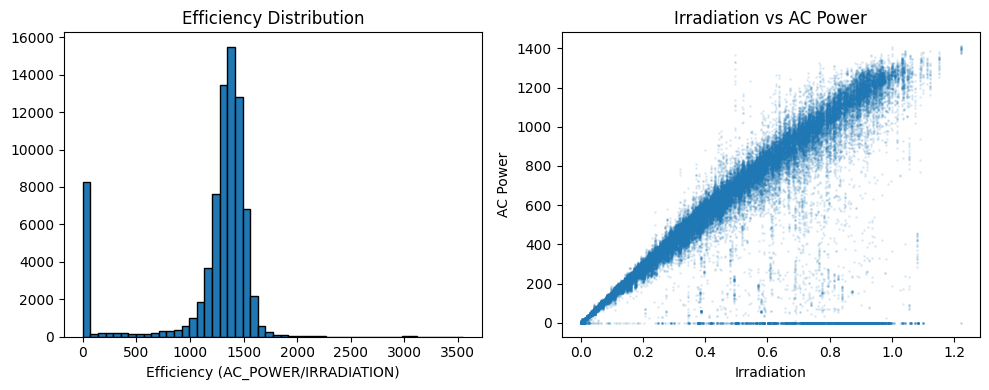

In [7]:
# Check efficiency distribution to understand what "normal" looks like
print(df_day['EFFICIENCY'].describe())
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df_day['EFFICIENCY'], bins=50, edgecolor='black')
plt.xlabel('Efficiency (AC_POWER/IRRADIATION)')
plt.title('Efficiency Distribution')
plt.subplot(1, 2, 2)
plt.scatter(df_day['IRRADIATION'], df_day['AC_POWER'], alpha=0.1, s=1)
plt.xlabel('Irradiation')
plt.ylabel('AC Power')
plt.title('Irradiation vs AC Power')
plt.tight_layout()
plt.show()

In [8]:
# Define underperformance: efficiency below 20th percentile for similar irradiation levels
# Group by irradiation bins to get expected efficiency
df_day['IRR_BIN'] = pd.cut(df_day['IRRADIATION'], bins=10, labels=False)

# Calculate median efficiency per irradiation bin
median_eff = df_day.groupby('IRR_BIN')['EFFICIENCY'].transform('median')
std_eff = df_day.groupby('IRR_BIN')['EFFICIENCY'].transform('std')

# Underperforming if efficiency is more than 1.5 std below median for that irradiation level
df_day['EXPECTED_EFF'] = median_eff
df_day['UNDERPERFORMING'] = ((df_day['EFFICIENCY'] < (median_eff - 1.5 * std_eff)) | (df_day['EFFICIENCY'] == 0)).astype(int)

print("Underperformance distribution:")
print(df_day['UNDERPERFORMING'].value_counts())
print(f"\nUnderperforming rate: {df_day['UNDERPERFORMING'].mean()*100:.2f}%")

Underperformance distribution:
UNDERPERFORMING
0    66635
1    10463
Name: count, dtype: int64

Underperforming rate: 13.57%


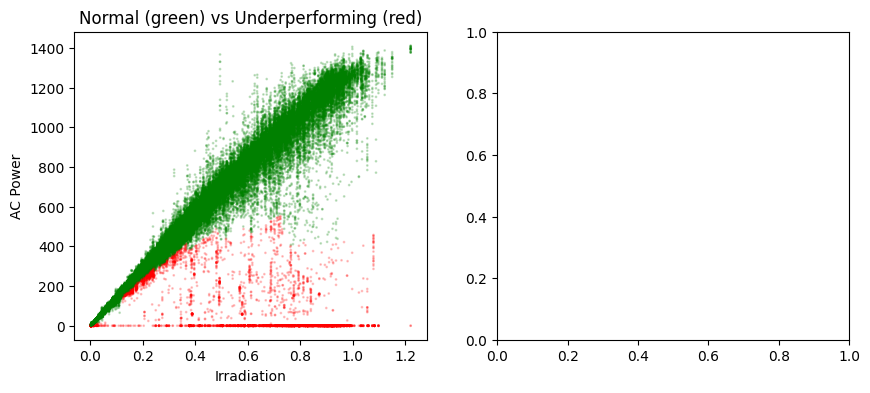

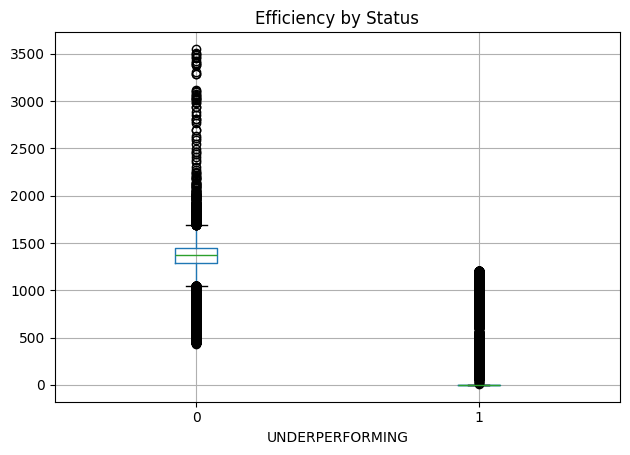

In [9]:
# Visualize underperforming vs normal
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
colors = ['green' if x == 0 else 'red' for x in df_day['UNDERPERFORMING']]
plt.scatter(df_day['IRRADIATION'], df_day['AC_POWER'], c=colors, alpha=0.2, s=1)
plt.xlabel('Irradiation')
plt.ylabel('AC Power')
plt.title('Normal (green) vs Underperforming (red)')

plt.subplot(1, 2, 2)
df_day.boxplot(column='EFFICIENCY', by='UNDERPERFORMING')
plt.title('Efficiency by Status')
plt.suptitle('')
plt.tight_layout()
plt.show()

In [10]:
# Prepare features for model
features = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'HOUR', 'TEMP_DIFF', 'AC_POWER']
X = df_day[features].copy()
y = df_day['UNDERPERFORMING'].copy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (61678, 6)
Test set: (15420, 6)


In [11]:
# Train RandomForest with limited depth to prevent overfitting
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Evaluate
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("=== Training Performance ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("\n=== Test Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Underperforming']))

=== Training Performance ===
Accuracy: 0.9889

=== Test Performance ===
Accuracy: 0.9875

Classification Report (Test):
                 precision    recall  f1-score   support

         Normal       0.99      1.00      0.99     13327
Underperforming       1.00      0.91      0.95      2093

       accuracy                           0.99     15420
      macro avg       0.99      0.96      0.97     15420
   weighted avg       0.99      0.99      0.99     15420



               feature  importance
5             AC_POWER    0.659291
0          IRRADIATION    0.215410
3                 HOUR    0.060625
4            TEMP_DIFF    0.034840
2   MODULE_TEMPERATURE    0.019234
1  AMBIENT_TEMPERATURE    0.010601


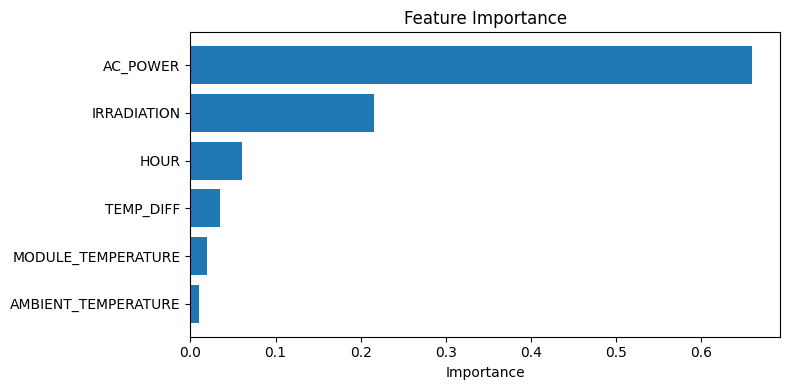

In [12]:
# Feature importance
feat_imp = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feat_imp = feat_imp.sort_values('importance', ascending=False)
print(feat_imp)

plt.figure(figsize=(8, 4))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [13]:
# Save model and scaler
import joblib

MODEL_PATH = "../models/"
joblib.dump(model, MODEL_PATH + "underperformance_model.joblib")
joblib.dump(scaler, MODEL_PATH + "scaler.joblib")
print("Model and scaler saved!")

Model and scaler saved!


In [14]:
# Test prediction function
def predict_underperformance(irradiation, ambient_temp, module_temp, hour, ac_power):
    """Returns 1 if underperforming, 0 if normal"""
    temp_diff = module_temp - ambient_temp
    features = np.array([[irradiation, ambient_temp, module_temp, hour, temp_diff, ac_power]])
    features_scaled = scaler.transform(features)
    return int(model.predict(features_scaled)[0])

# Test examples
print("Normal panel (high irradiation, high power):", predict_underperformance(0.8, 30, 45, 12, 1000))
print("Underperforming (high irradiation, low power):", predict_underperformance(0.8, 30, 45, 12, 50))
print("Low irradiation, low power (normal):", predict_underperformance(0.1, 25, 28, 8, 100))

Normal panel (high irradiation, high power): 0
Underperforming (high irradiation, low power): 1
Low irradiation, low power (normal): 0


d:\Database\Documents\Programming\PROJECTS\Solaria\ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\Database\Documents\Programming\PROJECTS\Solaria\ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\Database\Documents\Programming\PROJECTS\Solaria\ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
